In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Flatten, Dropout, Dense, Concatenate, Embedding
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model

In [125]:
class cGAN(keras.Model):
  def __init__(self):
    super(cGAN, self).__init__()
    self.latent_dim = 128
    self.img_shape = (28, 28, 1)
    self.n_classes = 10
    self.discriminator = self.build_disc()
    self.generator = self.build_gen()

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(cGAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  def train_step(self, data):
    real_image, label = data
    batch_size = tf.shape(real_image)[0]
    noise = tf.random.normal([batch_size, self.latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_image = self.generator([label, noise], training=True)

      real_output = self.discriminator([label, real_image], training=True)
      fake_output = self.discriminator([label, generated_image], training=True)

      d_loss = self.loss_fn(tf.ones_like(real_output), real_output) + self.loss_fn(tf.zeros_like(fake_output), fake_output)
      g_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)

    gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_weights)
    gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_weights)

    self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_weights))
    self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_weights))

    return {"d_loss": d_loss, "g_loss": g_loss}

  def plot_images(self):
    seed = tf.random.normal([4, 128])
    label = np.array([2, 4, 5, 9])
    predictions = self.generator([label,seed], training=False)
    print(type(predictions))

    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
      plt.subplot(1, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255.0, cmap="gray")
      plt.axis("off")
    plt.show()

  def build_disc(self):
    label = Input(shape=(1,))
    x0 = Embedding(self.n_classes, 50)(label)
    x0 = Dense(28*28*1)(x0)
    x0 = Reshape((28, 28, 1))(x0)

    image = Input(shape=self.img_shape)

    concat = Concatenate()([x0, image])
    x1 = Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding="same")(concat)
    x1 = LeakyReLU(alpha=0.2)(x1)

    x1 = Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding="same")(x1)
    x1 = LeakyReLU(alpha=0.2)(x1)

    x1 = Flatten()(x1)

    x1 = Dropout(0.5)(x1)

    output = Dense(1)(x1)

    model = Model([label, image], output)

    return model

  def build_gen(self):
    label = Input(shape=(1,))
    x0 = Embedding(self.n_classes, 50)(label)
    x0 = Dense(7*7*1)(x0)
    x0 = Reshape((7, 7, 1))(x0)

    z = Input(shape=(self.latent_dim,))
    x1 = Dense(7*7*128)(z)
    x1 = LeakyReLU(alpha=0.2)(x1)
    x1 = Reshape((7, 7, 128))(x1)

    concat = Concatenate()([x0, x1])
    x2 = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding="same")(concat)
    x2 = LeakyReLU(alpha=0.2)(x2)

    x2 = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding="same")(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)

    output = Conv2D(filters=1, kernel_size=(7,7), padding="same", activation="tanh")(x2)
    model = Model([label, z], output)

    return model
    

In [126]:
cgan = cGAN()

(X_train, y_train), (_, _) = keras.datasets.mnist.load_data()
X_train = (X_train.astype("float32") - 127.5) / 127.5
X_train = np.reshape(X_train, (-1, 28, 28, 1))
# y_train = to_categorical(y_train)

In [127]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(64)

In [128]:
cgan.compile(
  d_optimizer=keras.optimizers.Adam(learning_rate=3e-4),
  g_optimizer=keras.optimizers.Adam(learning_rate=3e-4),
  loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)
)

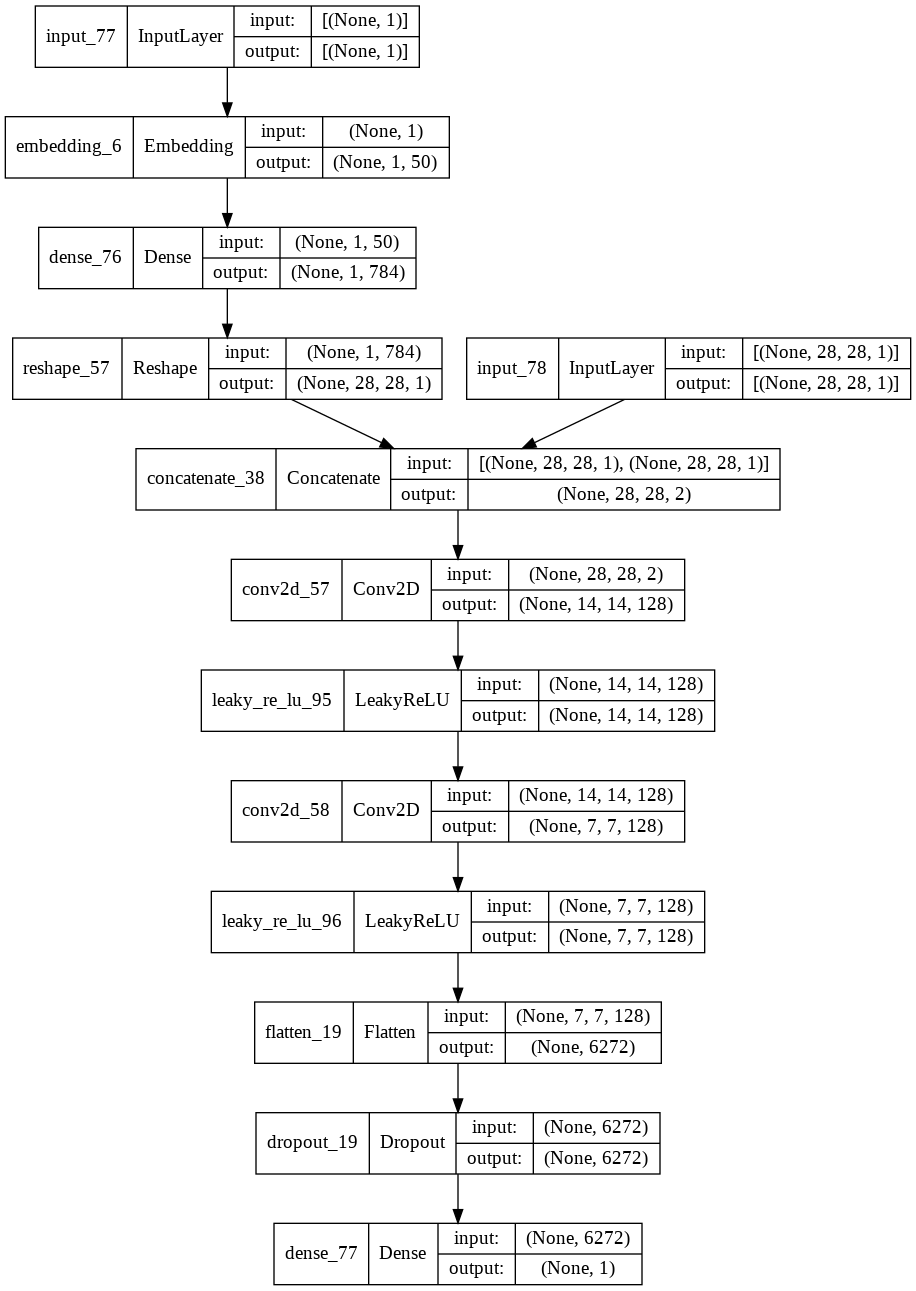

In [129]:
tf.keras.utils.plot_model(cgan.discriminator, to_file='disc.png', show_shapes=True, show_layer_names=True)

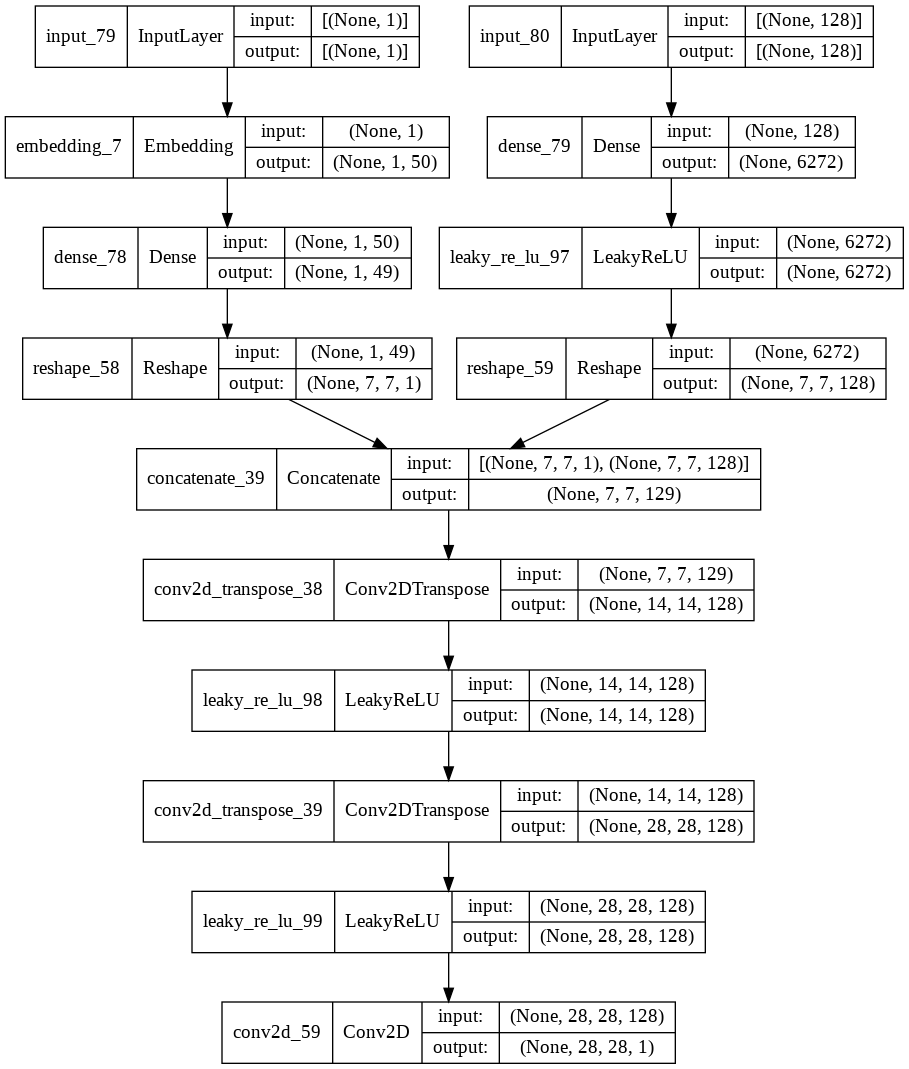

In [130]:
tf.keras.utils.plot_model(cgan.generator, to_file='gen.png', show_shapes=True, show_layer_names=True)

In [131]:
cgan.fit(dataset, epochs=20)

Epoch 1/20
938/938 [==============================] - 27s 27ms/step - d_loss: 0.0436 - g_loss: 7.8632
Epoch 2/20
938/938 [==============================] - 25s 27ms/step - d_loss: 0.4621 - g_loss: 8.4038
Epoch 3/20
938/938 [==============================] - 25s 27ms/step - d_loss: 0.2485 - g_loss: 4.7423
Epoch 4/20
938/938 [==============================] - 25s 27ms/step - d_loss: 0.1721 - g_loss: 4.0586
Epoch 5/20
938/938 [==============================] - 26s 27ms/step - d_loss: 0.7983 - g_loss: 3.6022
Epoch 6/20
938/938 [==============================] - 26s 27ms/step - d_loss: 1.1939 - g_loss: 1.0741
Epoch 7/20
938/938 [==============================] - 26s 27ms/step - d_loss: 1.1411 - g_loss: 1.1164
Epoch 8/20
938/938 [==============================] - 26s 27ms/step - d_loss: 0.9910 - g_loss: 1.3915
Epoch 9/20
938/938 [==============================] - 26s 27ms/step - d_loss: 1.0161 - g_loss: 1.3200
Epoch 10/20
938/938 [==============================] - 26s 27ms/step - d_loss: 1.0

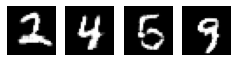

In [134]:
seed = tf.random.normal([4, 128])
label = np.array([2, 4, 5, 9])
predictions = cgan.generator([label,seed], training=False)


fig = plt.figure(figsize=(4,4))
for i in range(predictions.shape[0]):
  plt.subplot(1, 4, i+1)
  plt.imshow(predictions[i, :, :, 0] * 255.0, cmap="gray")
  plt.axis("off")
plt.show()